In [1]:
%matplotlib inline 
import torch
import torch.nn as nn 
import torch.nn.functional as F 
from torch.utils.data import Dataset, DataLoader 

import os 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import cv2

import librosa
import librosa.display
import skimage.io

**Preprocessing**

In [15]:
ravdess_emotions = {'01':'neutral', '02':'calm', '03':'happy', '04':'sad',\
                   '05':'angry', '06':'fear', '07':'disgust','08':'surprise'}

In [3]:
def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def spectrogram_image(y, sr, out, hop_length, n_mels):
    # use log-melspectrogram
    mels = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels,
                                            n_fft=hop_length*2, hop_length=hop_length)
    mels = np.log(mels + 1e-9) # add small number to avoid log(0)

    # min-max scale to fit inside 8-bit range
    img = scale_minmax(mels, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255-img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(out, img)

def get_image_path(file_path):
    path_list = file_path.split('/')
    img_path = path_list[-1]
    
     # settings
    hop_length = 512 # number of samples per time-step in spectrogram
    n_mels = 128 # number of bins in spectrogram. Height of image
    time_steps = 384 # number of time-steps. Width of image

    # load audio. Using example from librosa
    y, sr = librosa.load(file_path, offset=1.0, duration=10.0, sr=22050)
    out = 'data/images/' + img_path[:-4] + '.png'

    # extract a fixed length window
    start_sample = 0 # starting at beginning
    length_samples = time_steps*hop_length
    window = y[start_sample:start_sample+length_samples]
    
    # convert to PNG
    spectrogram_image(window, sr=sr, out=out, hop_length=hop_length, n_mels=n_mels)
    # print('wrote file', out)
    
    return out

In [5]:
processed_data = []
# Folder path of the data 
data_path = 'data/speech-emotion-recognition-ravdess-data/'

# Extracting Label of audio clip from the file name based on the name of the dataset. 
for root, dirs, files in os.walk(data_path):
    for file in files:
        if not file.endswith('.DS_Store'):
            file_path = os.path.join(root, file)
            # Split the file name based on dataset
            file_breakdown = file.split('-')
            if file_breakdown[3] == '01' and file_breakdown[5] == '01':
                emotion = ravdess_emotions[file_breakdown[2]]
                emotion_id = int(file_breakdown[2])
                statement = int(file_breakdown[4])
                actor = int(file_breakdown[6][:-4])
            
                img_path = get_image_path(file_path)
                #print(emotion)
                processed_data.append([file_path, actor, emotion, emotion_id, statement, img_path])
print("All Images Written")
# Compute Recipe Outputs: 
speech_data_processed_df = pd.DataFrame(processed_data, columns=['file_name','actor','emotions','emotion_id','statement','image_path'])

All Images Written


In [6]:
speech_data_processed_df.head()

,file_name,actor,emotions,emotion_id,statement,image_path
0,data/speech-emotion-recognition-ravdess-data/A...,16,angry,5,2,data/images/03-01-05-01-02-01-16.png
1,data/speech-emotion-recognition-ravdess-data/A...,16,disgust,7,1,data/images/03-01-07-01-01-01-16.png
2,data/speech-emotion-recognition-ravdess-data/A...,16,surprise,8,1,data/images/03-01-08-01-01-01-16.png
3,data/speech-emotion-recognition-ravdess-data/A...,16,calm,2,2,data/images/03-01-02-01-02-01-16.png
4,data/speech-emotion-recognition-ravdess-data/A...,16,happy,3,2,data/images/03-01-03-01-02-01-16.png


In [8]:
# Audio File: 
print(f"Audio: {speech_data_processed_df.file_name[0]}")
# Image File: 
print(f"Image: {speech_data_processed_df.image_path[0]}")

Audio: data/speech-emotion-recognition-ravdess-data/Actor_16/03-01-05-01-02-01-16.wav
Image: data/images/03-01-05-01-02-01-16.png


**Understanding Class Imbalance**

In [9]:
speech_data_processed_df.groupby('emotions').count()

,file_name,actor,emotion_id,statement,image_path
emotions,,,,,
angry,48,48,48,48,48
calm,48,48,48,48,48
disgust,48,48,48,48,48
fear,48,48,48,48,48
happy,48,48,48,48,48
neutral,48,48,48,48,48
sad,48,48,48,48,48
surprise,48,48,48,48,48


**Understanding Acoustic Feature Extraction**

In [10]:
import wave

In [11]:
sf_filewave = wave.open('data/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-01-01.wav')
signal_sf = sf_filewave.readframes(-1)

# Convert audio bytes to integers
soundwave_sf = np.frombuffer(signal_sf, dtype='int16')

# Get the sound wave frame rate 
framerate_sf = sf_filewave.getframerate()

# Find the sound wave timestamps 
time_sf = np.linspace(start=0, stop=len(soundwave_sf)/framerate_sf, num=len(soundwave_sf))

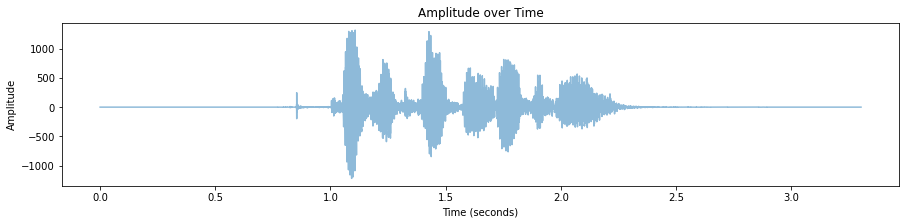

In [13]:
fig, ax = plt.subplots(figsize=(15,3))

# Setup the title and axis titles
plt.title('Amplitude over Time')
plt.ylabel('Amplitude')
plt.xlabel('Time (seconds)')
# Add the audio data to the plot
ax.plot(time_sf, soundwave_sf, alpha=0.5)
plt.savefig('audio_ex.png')

In [16]:
x, sr = librosa.load('data/speech-emotion-recognition-ravdess-data/Actor_01/03-01-01-01-01-02-01.wav', offset=1.0, duration=10.0, sr=22050)

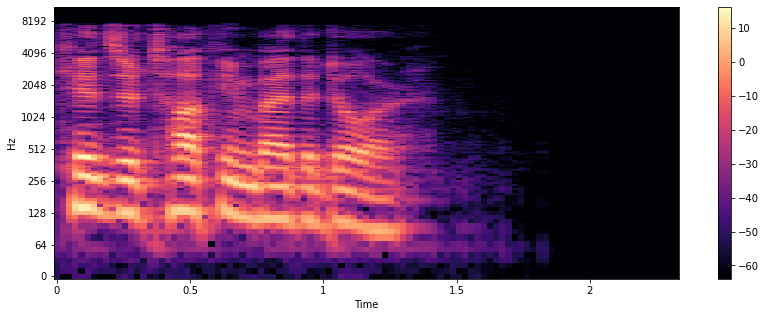

In [19]:
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
plt.colorbar()
plt.savefig('melSpec_ex.png')

**Sorting Dataframe**

In [20]:
speech_data_processed_df = speech_data_processed_df.sort_values(by=['actor','statement','emotion_id'], ignore_index=True)

In [21]:
speech_data_processed_df.head(16)

,file_name,actor,emotions,emotion_id,statement,image_path
0,data/speech-emotion-recognition-ravdess-data/A...,1,neutral,1,1,data/images/03-01-01-01-01-01-01.png
1,data/speech-emotion-recognition-ravdess-data/A...,1,calm,2,1,data/images/03-01-02-01-01-01-01.png
2,data/speech-emotion-recognition-ravdess-data/A...,1,happy,3,1,data/images/03-01-03-01-01-01-01.png
3,data/speech-emotion-recognition-ravdess-data/A...,1,sad,4,1,data/images/03-01-04-01-01-01-01.png
4,data/speech-emotion-recognition-ravdess-data/A...,1,angry,5,1,data/images/03-01-05-01-01-01-01.png
5,data/speech-emotion-recognition-ravdess-data/A...,1,fear,6,1,data/images/03-01-06-01-01-01-01.png
6,data/speech-emotion-recognition-ravdess-data/A...,1,disgust,7,1,data/images/03-01-07-01-01-01-01.png
7,data/speech-emotion-recognition-ravdess-data/A...,1,surprise,8,1,data/images/03-01-08-01-01-01-01.png
8,data/speech-emotion-recognition-ravdess-data/A...,1,neutral,1,2,data/images/03-01-01-01-02-01-01.png
9,data/speech-emotion-recognition-ravdess-data/A...,1,calm,2,2,data/images/03-01-02-01-02-01-01.png


In [22]:
speech_data_processed_df.to_csv('data/RAVDESS_processed_dataset.csv')

**Notes:**
for the dataset and dataloader

We want it to return:
> x, y \
(1 image - Emotion , All 8 images - Emotions)

> Image: Tensor X: [batch_size,1,H,W] Y: [batch_size, 8, H, W]

Model: \
GAN: 1 image to all other images
Loss: 6 Predicted vs 6 Actual [for that actor] 

1 Emotion translate to all other emotions 

In [18]:
speech_df = pd.read_csv('data/RAVDESS_processed_dataset.csv')
speech_df.head(8)

,Unnamed: 0,file_name,actor,emotions,emotion_id,statement,image_path
0,0,data/speech-emotion-recognition-ravdess-data/A...,1,neutral,1,1,data/images/03-01-01-01-01-01-01.png
1,1,data/speech-emotion-recognition-ravdess-data/A...,1,calm,2,1,data/images/03-01-02-01-01-01-01.png
2,2,data/speech-emotion-recognition-ravdess-data/A...,1,happy,3,1,data/images/03-01-03-01-01-01-01.png
3,3,data/speech-emotion-recognition-ravdess-data/A...,1,sad,4,1,data/images/03-01-04-01-01-01-01.png
4,4,data/speech-emotion-recognition-ravdess-data/A...,1,angry,5,1,data/images/03-01-05-01-01-01-01.png
5,5,data/speech-emotion-recognition-ravdess-data/A...,1,fear,6,1,data/images/03-01-06-01-01-01-01.png
6,6,data/speech-emotion-recognition-ravdess-data/A...,1,disgust,7,1,data/images/03-01-07-01-01-01-01.png
7,7,data/speech-emotion-recognition-ravdess-data/A...,1,surprise,8,1,data/images/03-01-08-01-01-01-01.png


In [19]:
emotions = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fear', 'Disgust', 'Surprise']
len(emotions)

8

**Dataset**

In [3]:
class EmotionDataset(Dataset):
    def __init__(self, df, transform=None):
        self.imgs_files = [f for f in df.image_path.values]
        self.label = [f for f in df['emotion_id'].values]
    
    def __len__(self): 
        return len(self.label)
    
    def _getname__(self, idx): 
        return self.label[idx]
    
    def __getitem__(self, idx):
        i = idx%8
        idx = int(idx/8) 
        
        img_paths = self.imgs_files[8*idx:8*idx+8]
        label = self.label[idx]
        
        imgs = []
        # Read Image:
        for img_path in img_paths: 
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
                
        images = torch.from_numpy(np.array(imgs))
        
        #print(i)
        return images[i].unsqueeze(0), images

In [4]:
train_ds = EmotionDataset(speech_df)

In [9]:
x,y = train_ds.__getitem__(3)
happy, [all batch 1]

3


In [ ]:
x,y = train_ds.__getitem__(4)
sad, [all batch 1]

In [ ]:
x,y = train_ds.__getitem__(9)
calm, [all batch 2]

The way it works: 

i = 0,1,2,3,4,5,6,7

calm -> model(calm) -> produce 8 different \
i=0: 
pair 8 diff with the 8 actual..  [[real neutral,fake sad], [real neutral,fake happy], ..,[real neutral,fake calm]]\
pair 8 actual with the 8 actual..? [[real neutral,real sad], [real neutral,real happy], ..[real neutral,real calm]]\

i=1:
pair 8 diff with the 8 actual..  [[real calm, fake sad] , [real calm, fake happy], .., [real calm , fake calm]]\
pair 8 actual with the 8 actual..? [[real calm, real sad] , [real calm, real happy], .. [real calm, real calm]]

Start by labeling >> 0: fake, 1: real (pairs) \
[0,0,0,0,0,0,0,0]
[1,1,1,1,1,1,1,1]

In [7]:
x.size(), y.size()

(torch.Size([1, 128, 128]), torch.Size([8, 128, 128]))

**checking math**

In [46]:
ex = [1,2,3,4,5,6,7,8,\
      11,12,13,14,15,16,17,18,\
      21,22,23,24,25,26,27,28]
array = np.array(ex)

In [47]:
array

array([ 1,  2,  3,  4,  5,  6,  7,  8, 11, 12, 13, 14, 15, 16, 17, 18, 21,
       22, 23, 24, 25, 26, 27, 28])

In [48]:
for idx in range(len(array)): 
    i = idx%8
    print(i)
    idx = int(idx/8)
    print(idx)
    print(array[8*idx:8*idx+8])

0
0
[1 2 3 4 5 6 7 8]
1
0
[1 2 3 4 5 6 7 8]
2
0
[1 2 3 4 5 6 7 8]
3
0
[1 2 3 4 5 6 7 8]
4
0
[1 2 3 4 5 6 7 8]
5
0
[1 2 3 4 5 6 7 8]
6
0
[1 2 3 4 5 6 7 8]
7
0
[1 2 3 4 5 6 7 8]
0
1
[11 12 13 14 15 16 17 18]
1
1
[11 12 13 14 15 16 17 18]
2
1
[11 12 13 14 15 16 17 18]
3
1
[11 12 13 14 15 16 17 18]
4
1
[11 12 13 14 15 16 17 18]
5
1
[11 12 13 14 15 16 17 18]
6
1
[11 12 13 14 15 16 17 18]
7
1
[11 12 13 14 15 16 17 18]
0
2
[21 22 23 24 25 26 27 28]
1
2
[21 22 23 24 25 26 27 28]
2
2
[21 22 23 24 25 26 27 28]
3
2
[21 22 23 24 25 26 27 28]
4
2
[21 22 23 24 25 26 27 28]
5
2
[21 22 23 24 25 26 27 28]
6
2
[21 22 23 24 25 26 27 28]
7
2
[21 22 23 24 25 26 27 28]


**Plotting All Emotions**

In [36]:
sample_audios = [audio_path for audio_path in speech_df.file_name[0:8]]    

In [44]:
img, all_images = train_ds.__getitem__(0)

0


In [45]:
all_images.size()

torch.Size([8, 128, 128])

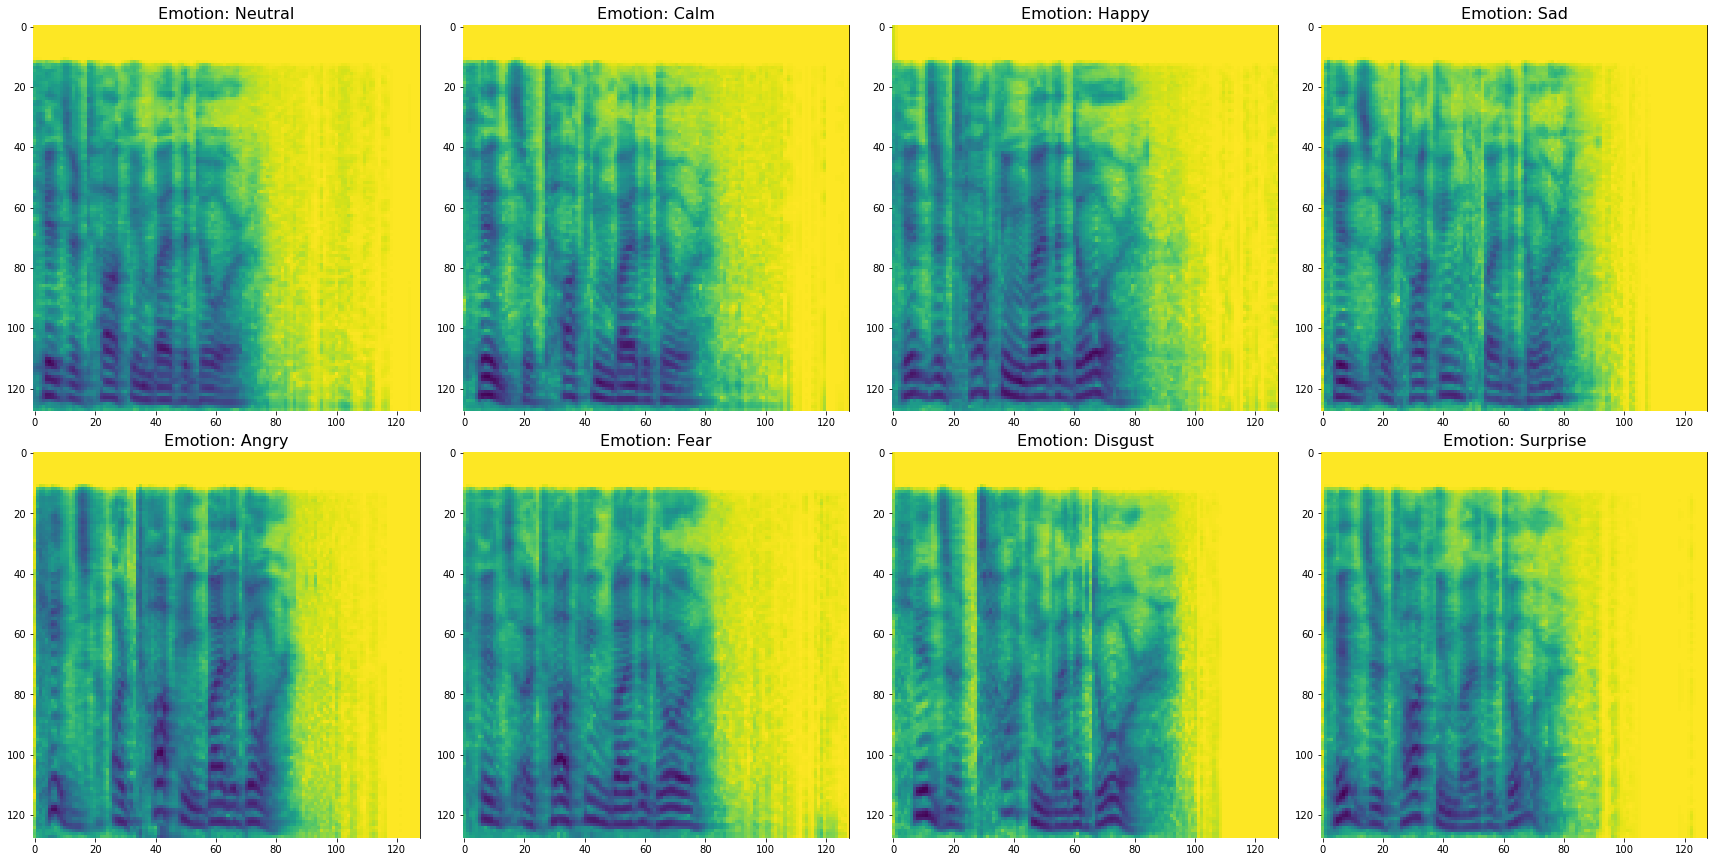

In [50]:
fig, ax = plt.subplots(2,4, figsize=(24,12))
k= 0 
for i in range(2):
    for j in range(4):
        ax[i,j].imshow(all_images.numpy()[k])
        ax[i,j].set_title(f"Emotion: {emotions[k]}", fontsize=16)
        ax[i,j].spines['top'].set_visible(False)
        ax[i,j].spines['left'].set_visible(False)
        ax[i,j].spines['bottom'].set_visible(False)


        k +=1
plt.tight_layout()
plt.show()